Loading and preparing data...

### Starting Final Model Bake-Off ###
  Analyzing Subject 1...
  Analyzing Subject 2...
  Analyzing Subject 3...
  Analyzing Subject 4...
  Analyzing Subject 5...
  Analyzing Subject 6...
  Analyzing Subject 7...
  Analyzing Subject 8...
  Analyzing Subject 9...
  Analyzing Subject 10...
  Analyzing Subject 11...
  Analyzing Subject 12...

--- Final Bake-Off Summary ---
    subject_id  Online Bayesian  Switching           winner
0            1          1046.76    1982.63  Online Bayesian
1            2          1963.44    1793.04        Switching
2            3           966.59    2105.63  Online Bayesian
3            4          1801.26    2263.09  Online Bayesian
4            5          3704.77    5134.14  Online Bayesian
5            6          2160.86    3412.41  Online Bayesian
6            7          1454.42    2467.83  Online Bayesian
7            8          3768.36    4157.99  Online Bayesian
8            9          1921.92    2933.90  Online Bayes

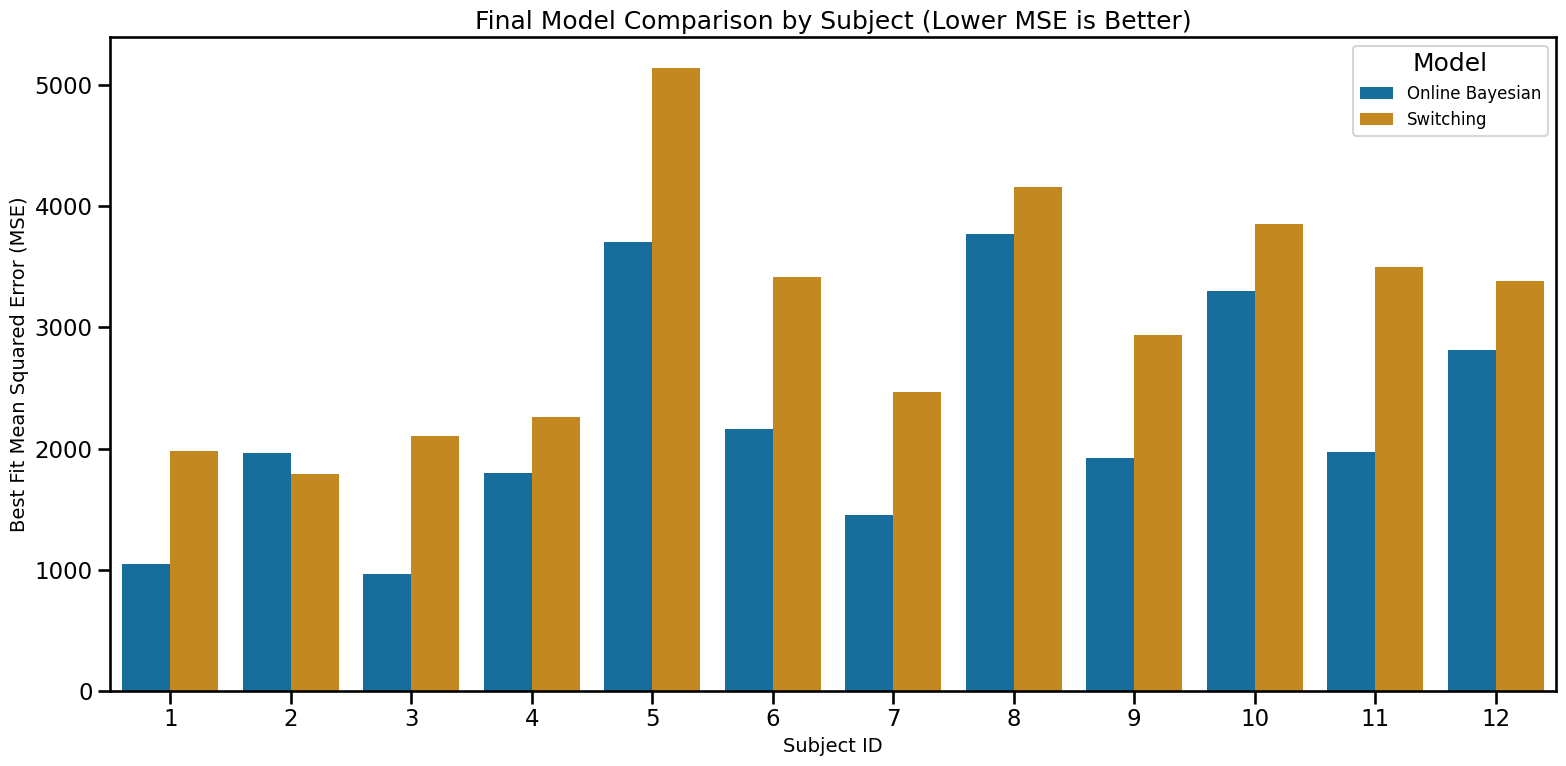

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

def circular_distance(angle1, angle2):
    """Calculates the shortest signed distance between two angles in degrees."""
    diff = angle1 - angle2
    return (diff + 180) % 360 - 180

class FinalModelBakeOff:
    """
    Compares the Online Bayesian and Switching models
    for all subjects to determine the best-fitting perceptual strategy.
    """
    def __init__(self, file_path):
        self.df_full = self._load_and_prepare_data(file_path)
        self.subjects = sorted(self.df_full['subject_id'].unique())
        self.results = []

    def _load_and_prepare_data(self, file_path):
        """Loads and prepares the dataset."""
        print("Loading and preparing data...")
        df = pd.read_csv(file_path)
        df = df.sort_values(by=['subject_id', 'run_id', 'trial_index']).reset_index(drop=True)
        df['estimate_angle'] = np.degrees(np.arctan2(df['estimate_y'], df['estimate_x']))
        df = df.dropna(subset=['estimate_angle', 'motion_coherence']).reset_index(drop=True)
        return df

    def run_online_bayesian_model(self, df_subject):
        """Finds the best-fitting Online Bayesian model for a subject."""
        learning_rates = [0.01, 0.05, 0.1]
        best_mse = float('inf')
        for lr in learning_rates:
            errors = self._simulate_online_bayesian_run(df_subject, lr)
            mse = np.mean(errors**2)
            if mse < best_mse:
                best_mse = mse
        return best_mse

    def _simulate_online_bayesian_run(self, df, learning_rate):
        df = df.copy()
        df['sin_motion'] = np.sin(np.deg2rad(df['motion_direction']))
        df['cos_motion'] = np.cos(np.deg2rad(df['motion_direction']))
        df['sin_prior'] = np.sin(np.deg2rad(df['prior_mean']))
        df['cos_prior'] = np.cos(np.deg2rad(df['prior_mean']))
        predictions = np.zeros(len(df))
        ke, kp = 5.0, 2.0  # Initial confidence parameters
        for idx, (_, trial) in enumerate(df.iterrows()):
            sin_post = ke * trial['sin_motion'] + kp * trial['sin_prior']
            cos_post = ke * trial['cos_motion'] + kp * trial['cos_prior']
            pred_angle = np.rad2deg(np.arctan2(sin_post, cos_post))
            predictions[idx] = pred_angle
            error_rad = np.deg2rad(circular_distance(pred_angle, trial['motion_direction']))
            d_err_d_ke = (trial['sin_motion'] * cos_post - trial['cos_motion'] * sin_post) / (sin_post**2 + cos_post**2)
            d_err_d_kp = (trial['sin_prior'] * cos_post - trial['cos_prior'] * sin_post) / (sin_post**2 + cos_post**2)
            ke = max(0, ke - learning_rate * error_rad * d_err_d_ke)
            kp = max(0, kp - learning_rate * error_rad * d_err_d_kp)
        return circular_distance(predictions, df['estimate_angle'])

    def run_switching_model(self, df_subject):
        """Finds the best-fitting Switching model for a subject."""
        best_mse = float('inf')
        for kp in np.linspace(0.1, 15.0, 20):
            mse = self._simulate_switching_run(df_subject, kp)
            if mse < best_mse:
                best_mse = mse
        return mse

    def _simulate_switching_run(self, df, kp):
        df = df.copy()
        ke_map = {0.06: 5.0, 0.12: 10.0, 0.24: 20.0}
        df['ke'] = df['motion_coherence'].map(ke_map)
        p_switch = kp / (kp + df['ke'])
        predictions = np.where(np.random.rand(len(df)) < p_switch, df['prior_mean'], df['motion_direction'])
        return np.mean(circular_distance(predictions, df['estimate_angle'])**2)

    def run_final_comparison(self):
        """Runs the two final models for all subjects."""
        print("\n### Starting Final Model Bake-Off ###")
        for sid in self.subjects:
            print(f"  Analyzing Subject {sid}...")
            df_sub = self.df_full[self.df_full['subject_id'] == sid]
            self.results.append({
                'subject_id': sid,
                'Online Bayesian': self.run_online_bayesian_model(df_sub),
                'Switching': self.run_switching_model(df_sub)
            })
        self.results_df = pd.DataFrame(self.results)
        return self.results_df

    def plot_summary(self):
        """Plots the final comparison of the two models."""
        if not hasattr(self, 'results_df'):
            print("Please run run_final_comparison() first.")
            return

        self.results_df['winner'] = self.results_df.apply(
            lambda row: 'Online Bayesian' if row['Online Bayesian'] < row['Switching'] else 'Switching',
            axis=1
        )
        print("\n--- Final Bake-Off Summary ---")
        print(self.results_df.round(2))

        plot_df = self.results_df.melt(id_vars='subject_id', value_vars=['Online Bayesian', 'Switching'],
                                       var_name='Model', value_name='MSE')

        sns.set_context("talk")
        plt.figure(figsize=(16, 8))
        sns.barplot(x='subject_id', y='MSE', hue='Model', data=plot_df, palette='colorblind')
        plt.title('Final Model Comparison by Subject (Lower MSE is Better)', fontsize=18)
        plt.xlabel('Subject ID', fontsize=14)
        plt.ylabel('Best Fit Mean Squared Error (MSE)', fontsize=14)
        plt.legend(title='Model', fontsize=12)
        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    warnings.filterwarnings('ignore')
    comparator = FinalModelBakeOff("data01_direction4priors.csv")
    comparator.run_final_comparison()
    comparator.plot_summary()